# Split the data into training and test sets

In [1]:
import random
import colorsys
import pandas as pd
import matplotlib
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

In [2]:
RAND_STATE = 333

random.seed(RAND_STATE)

## Load metadata

In [3]:
sample_metadata = pd.read_csv("../data/merged_metadata.tsv", sep="\t", index_col=0, keep_default_na=False)
sample_metadata 

,Age,Gender,Status,TotalNumReads,NumUniquelyMappedReads,UniquelyMappedReadsPercentage,CancerSubtype,ChemotherapyStatus,GnRHTherapyStatus,TAMTherapyStatus,AITherapyStatus,BSOTherapyStatus
SampleID,,,,,,,,,,,,
C1,34.44,Female,C-R,"7,293,272","6,044,825",82.88%,TripleNegative,D,N/A,N/A,N/A,N/A
C2,43.35,Female,C-R,"7,870,895","6,526,361",82.92%,TripleNegative,A,N/A,N/A,N/A,N/A
C3,43.85,Female,C-R,"6,622,312","5,620,525",84.87%,TripleNegative,A,N/A,N/A,N/A,N/A
C4,41.42,Female,C-R,"8,248,171","7,041,599",85.37%,TripleNegative,A,N/A,N/A,N/A,N/A
C5,42.12,Female,C-R,"9,233,397","7,922,603",85.80%,LuminalA/Normal-like,D,B,B,N/A,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...
N28,29.00,Female,N,"8,579,794","7,286,744",84.93%,,,,,,
N29,32.00,Female,N,"10,808,607","8,789,442",81.32%,,,,,,
N30,41.00,Female,N,"7,312,205","5,604,035",76.64%,,,,,,


## Inspect the metadata

In [4]:
status_vals = sorted(list(sample_metadata["Status"].unique()))
print(f"The {len(status_vals)} unique statuses are {', '.join(status_vals)}.")

The 3 unique statuses are C-N, C-R, N.


### How many samples are there from each "status" group?

C-N    68
N      32
C-R    28
Name: Status, dtype: int64 Index(['C-N', 'N', 'C-R'], dtype='object')
x ['C-N', 'C-R', 'N']
y [68, 28, 32]


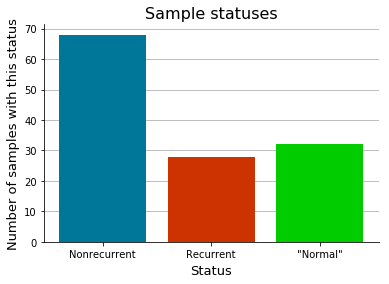

In [5]:
val_counts = sample_metadata["Status"].value_counts()
print(val_counts, val_counts.index)
x = status_vals
y = [val_counts[s] for s in x]

print("x", x)
print("y", y)

fig, ax = pyplot.subplots(1)
ax.bar(x, y, color=["#007799", "#cc3300", "#00cc00"], zorder=100)
ax.set_xlabel("Status", fontsize=13, labelpad=5)
ax.set_ylabel("Number of samples with this status", fontsize=13)
ax.set_title("Sample statuses", fontsize=16)

val2hrval = {"C-N": "Nonrecurrent", "C-R": "Recurrent", "N": '"Normal"'}
ax.set_xticklabels(val2hrval[v] for v in x)

# Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
# From https://stackoverflow.com/a/23358722.
ax.grid(axis="y", zorder=0)

# To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("../figs/sample_status_freq.png", bbox_inches="tight")

As we can see, we've got many more `C-N` samples than `C-R` or `N` samples.

### Of the cancer samples, how many samples represent each cancer subtype?

C-N counts
LuminalA/Normal-like    38
TripleNegative          14
LuminalB                12
HER2Enriched             4
Name: CancerSubtype, dtype: int64

C-R counts
TripleNegative          12
LuminalA/Normal-like    10
HER2Enriched             6
Name: CancerSubtype, dtype: int64


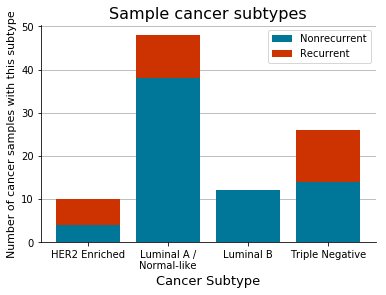

In [6]:
cancer_metadata = sample_metadata.loc[sample_metadata["Status"] != "N"]
subtype_vals = sorted(list(cancer_metadata["CancerSubtype"].unique()))

cn = cancer_metadata.loc[cancer_metadata["Status"] == "C-N"]
cr = cancer_metadata.loc[cancer_metadata["Status"] == "C-R"]

cnvc = cn["CancerSubtype"].value_counts()
crvc = cr["CancerSubtype"].value_counts()

print("C-N counts\n==========")
print(cnvc)
print("\nC-R counts\n==========")
print(crvc)

fig, ax = pyplot.subplots(1)

cnvc_y = [cnvc[v] if v in cnvc else 0 for v in subtype_vals]
ax.bar(subtype_vals, cnvc_y, color="#007799", zorder=100, label="Nonrecurrent")

# Show a stacked bar chart using the bottom parameter:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html
crvc_y = [crvc[v] if v in crvc else 0 for v in subtype_vals]
ax.bar(subtype_vals, crvc_y, color="#cc3300", zorder=100, bottom=cnvc_y, label="Recurrent")


val2hrval = {
    "LuminalA/Normal-like": "Luminal A /\nNormal-like",
    "TripleNegative": "Triple Negative",
    "LuminalB": "Luminal B",
    "HER2Enriched": "HER2 Enriched"
}
ax.set_xticklabels(val2hrval[v] for v in subtype_vals)
ax.set_xlabel("Cancer Subtype", fontsize=13)
ax.set_ylabel("Number of cancer samples with this subtype", fontsize=11)
ax.set_title("Sample cancer subtypes", fontsize=16)

ax.legend()

# Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
# From https://stackoverflow.com/a/23358722.
ax.grid(axis="y", zorder=0)

# To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("../figs/sample_cancer_subtype_freq.png", bbox_inches="tight")

### Of the cancer samples for each cancer subtype, what are the chemotherapy statuses?

From the Table S4 caption:

> [T]herapy status B: Serum was collected before the treatment started.
>
> Therapy status D: Serum was collected while the treatment was in progress.
>
> Therapy status A: Serum was collected after the treatment ended.

In [7]:
# Make sure there aren't any unexpected values
chemo_status_vals = sorted(cancer_metadata["ChemotherapyStatus"].unique())
chemo_status_vals

['A', 'B', 'D']

Nonrecurrent: Before counts
LuminalA/Normal-like    1
Name: CancerSubtype, dtype: int64

Nonrecurrent: During counts
LuminalA/Normal-like    11
TripleNegative           4
LuminalB                 4
HER2Enriched             1
Name: CancerSubtype, dtype: int64

Nonrecurrent: After counts
LuminalA/Normal-like    26
TripleNegative          10
LuminalB                 8
HER2Enriched             3
Name: CancerSubtype, dtype: int64

Recurrent: Before counts
Series([], Name: CancerSubtype, dtype: int64)
Not plotting anything since no samples have this configuration.

Recurrent: During counts
TripleNegative          3
HER2Enriched            1
LuminalA/Normal-like    1
Name: CancerSubtype, dtype: int64

Recurrent: After counts
LuminalA/Normal-like    9
TripleNegative          9
HER2Enriched            5
Name: CancerSubtype, dtype: int64


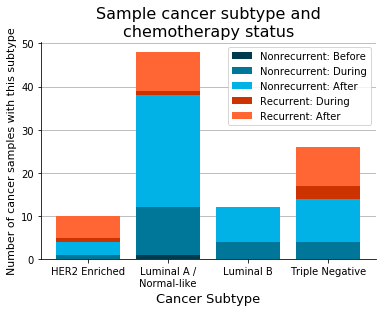

In [8]:
fig, ax = pyplot.subplots(1)

before_layer = None

def plot_df(df, color, label):
    global before_layer
    df_cancer_valcts = df["CancerSubtype"].value_counts()
    
    if before_layer is not None:
        print("")
    print(label, "counts\n==========")
    print(df_cancer_valcts)
    
    if sum(df_cancer_valcts) == 0:
        print("Not plotting anything since no samples have this configuration.")
        return
    
    y = [df_cancer_valcts[v] if v in df_cancer_valcts else 0 for v in subtype_vals]
    ax.bar(subtype_vals, y, color=color, label=label, zorder=100, bottom=before_layer)
    if before_layer is None:
        before_layer = y
    else:
        for i in range(len(before_layer)):
            before_layer[i] += y[i]

for cancer_metadata_df, labelprefix, basecolor in ((cn, "Nonrecurrent", "#007799"), (cr, "Recurrent", "#cc3300")):
    
    # We adjust the lightness of the "basecolor" so that the Before/During/After colors for each category
    # look similar, just with different lightnesses. This is done by converting the colors to HLS, then scaling
    # the lightness parameter. This solution was based on https://stackoverflow.com/a/49601444 (primarily)
    # and https://stackoverflow.com/a/60562502 (was useful for selecting lightness scales).
    hls_basecolor = colorsys.rgb_to_hls(*matplotlib.colors.to_rgb(basecolor))
    
    for ts, labelsuffix in (("B", "Before"), ("D", "During"), ("A", "After")): 
        
        df = cancer_metadata_df.loc[cancer_metadata_df["ChemotherapyStatus"] == ts]
        
        if ts == "B":
            scale = 0.5
        elif ts == "D":
            scale = 1
        else:
            scale = 1.5
        color = colorsys.hls_to_rgb(hls_basecolor[0], scale * hls_basecolor[1], hls_basecolor[2])
        plot_df(df, color, f"{labelprefix}: {labelsuffix}")

val2hrval = {
    "LuminalA/Normal-like": "Luminal A /\nNormal-like",
    "TripleNegative": "Triple Negative",
    "LuminalB": "Luminal B",
    "HER2Enriched": "HER2 Enriched"
}
ax.set_xticklabels(val2hrval[v] for v in subtype_vals)
ax.set_xlabel("Cancer Subtype", fontsize=13)
ax.set_ylabel("Number of cancer samples with this subtype", fontsize=11)
ax.set_title("Sample cancer subtype and\nchemotherapy status", fontsize=16)

ax.legend()

# Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
# From https://stackoverflow.com/a/23358722.
ax.grid(axis="y", zorder=0)

# To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("../figs/sample_cancer_subtype_chemo_status_freq.png", bbox_inches="tight")

### Of the "normal" samples, how many are from female vs. male patients?

(All of the cancer samples are from female patients.)

Male      16
Female    16
Name: Gender, dtype: int64


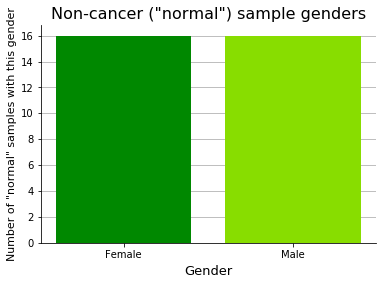

In [9]:
norm_samples = sample_metadata.loc[sample_metadata["Status"] == "N"]
gender_vals = sorted(list(norm_samples["Gender"].unique()))
gvc = norm_samples["Gender"].value_counts()
print(gvc)

fig, ax = pyplot.subplots(1)
ax.bar(gender_vals, [gvc[v] for v in gender_vals], color=["#008800", "#88dd00"], zorder=100)
ax.set_xlabel("Gender", fontsize=13, labelpad=5)
ax.set_ylabel("Number of \"normal\" samples with this gender", fontsize=11)
ax.set_title('Non-cancer ("normal") sample genders', fontsize=16)

# Draw a horizontal grid, but behind the bars: to do this we use distinct zorders.
# From https://stackoverflow.com/a/23358722.
ax.grid(axis="y", zorder=0)

# To make the plot look prettier (?) hide the top and right lines. From https://stackoverflow.com/a/28720127.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig("../figs/normal_sample_gender_freq.png", bbox_inches="tight")

### What are the age breakdowns?

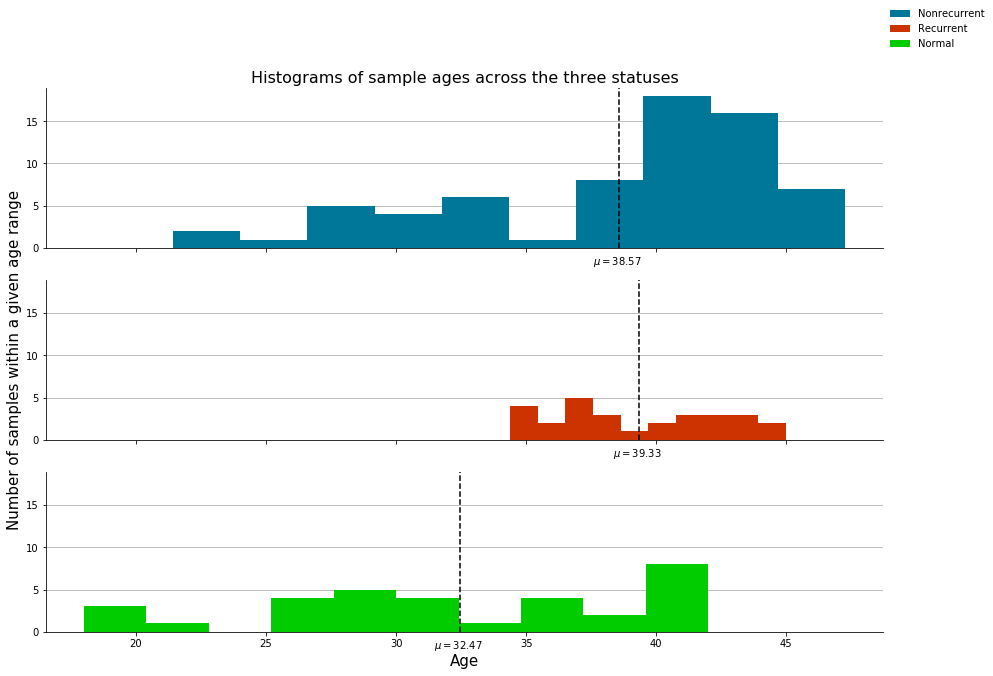

In [10]:
def plot_mean(ax, df):
    meanage = df["Age"].mean()
    ax.axvline(x = meanage, linestyle="--", zorder=200, color="#000000")
    ax.text(x = meanage - 1, y = -2, s=f"$\mu = {meanage:.2f}$", zorder=300)

fig, [ax1, ax2, ax3] = pyplot.subplots(3, sharex=True, sharey=True)

ax1.hist(cn["Age"], color="#007799", zorder=100, label="Nonrecurrent")
ax2.hist(cr["Age"], color="#cc3300", zorder=100, label="Recurrent")
ax3.hist(norm_samples["Age"], color="#00cc00", zorder=100, label="Normal")

plot_mean(ax1, cn)
plot_mean(ax2, cr)
plot_mean(ax3, norm_samples)

ax2.set_ylabel("Number of samples within a given age range", fontsize=15)
ax3.set_xlabel("Age", fontsize=15, labelpad=5)
ax1.set_title('Histograms of sample ages across the three statuses', fontsize=16)

fig.legend(frameon=False)

for ax in (ax1, ax2, ax3):
    ax.grid(axis="y", zorder=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_size_inches(15, 10)
fig.savefig("../figs/sample_age_hist.png", bbox_inches="tight")

## Actually split up the dataset!

We'll create a new `TrainTest` column and export a "final" sample metadata file that includes this column.

**For C-R and C-N samples**, we split them up by cancer subtype and then by chemotherapy status, and split up all of those categories individually. The goal is trying to prevent a single category of samples being unique to **just** the training or test datasets.

In practice that is unavoidable since some specific configurations of recurrence status / cancer subtype / chemotherapy status only apply to 1 sample, but we do our best.

**For normal (N) samples**, we just split up these samples by gender. As shown above there are an even number of normal samples for each gender (both have 16 samples, and 16 is evenly divisible by 4), so this works out well.

In [11]:
sample_metadata["TrainTest"] = ""

def update_ttsplit(sample_id_list, verbose=True):
    
    # If no samples were passed, don't do anything. This often happens due to e.g. cancer subtype + chemotherapy
    # values being absent for a given configuration (e.g. most subtypes don't have any Before-chemotherapy samples)
    if len(sample_id_list) == 0:
        training_samples, test_samples = [], []
        
    # If only one sample was passed, sklearn gets angry because it means we'll have an empty training or test
    # sample set for this category. In these cases we just make an arbitrary decision on where to put the sample.
    # (We've already fixed the random module's seed above, so this should be reproducible.)
    elif len(sample_id_list) == 1:
        if random.random() >= 0.5:
            training_samples = sample_id_list
            test_samples = []
        else:
            test_samples = sample_id_list
            training_samples = []
        
    # If we've got at least two samples, we can use sklearn to divvy up them between training and test.
    else:    
        # We use the default split amounts provided by train_test_split: 25% test, 75% training. Since the
        # numbers of samples we have in each status group are all divisible by 4, this works out nicely.
        #
        # Use of train_test_split() and a random state for consistency's sake suggested by
        # https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/.
        training_samples, test_samples = train_test_split(sample_id_list, random_state=RAND_STATE)
    
    # Iteration is sorta inefficient in pandas, but since this DF only has 128 rows it really doesn't matter
    for sample in training_samples:
        sample_metadata.loc[sample, "TrainTest"] = "Train"
    for sample in test_samples:
        sample_metadata.loc[sample, "TrainTest"] = "Test"
        
    if verbose:
        print(f"Train: {list(training_samples)}")
        print(f"Test: {list(test_samples)}")
        
    return training_samples, test_samples
        
for status in status_vals:
    samples_with_status = sample_metadata.loc[sample_metadata["Status"] == status]
    if status != "N":
        for subtype in subtype_vals:
            status_samples_with_subtype = samples_with_status.loc[samples_with_status["CancerSubtype"] == subtype]
            for chemo_status in chemo_status_vals:
                status_samples_with_subtype_and_chemo_status = status_samples_with_subtype.loc[
                    status_samples_with_subtype["ChemotherapyStatus"] == chemo_status
                ]
                ns = len(status_samples_with_subtype_and_chemo_status.index)
                training_samples, test_samples = update_ttsplit(status_samples_with_subtype_and_chemo_status.index)
                print(f"Just assigned {ns} sample(s) for status {status}, subtype {subtype}, chemo {chemo_status}.\n")
    else:
        for gender in gender_vals:
            norm_samples_with_gender = samples_with_status.loc[samples_with_status["Gender"] == gender]
            ns = len(norm_samples_with_gender.index)
            training_samples, test_samples = update_ttsplit(norm_samples_with_gender.index)
            print(f"Just assigned {ns} samples for status {status}, gender {gender}.\n")
        
    tt = sample_metadata.loc[sample_metadata["Status"] == status]["TrainTest"]
    ttvc = tt.value_counts()
    num_test = ttvc["Test"]
    num_train = ttvc["Train"]
    print((
        f"For status {status}, which has {val_counts[status]} samples, there are "
        f"{num_test} / {val_counts[status]} ({100 * num_test / val_counts[status]:.1f}%) "
        "test samples and "
        f"{num_train} / {val_counts[status]} ({100 * num_train / val_counts[status]:.1f}%) "
        "training samples."
    ))
    print("=" * 79)
sample_metadata.to_csv("../data/final_metadata.tsv", sep="\t")

Train: ['C72', 'C67']
Test: ['C68']
Just assigned 3 sample(s) for status C-N, subtype HER2Enriched, chemo A.

Train: []
Test: []
Just assigned 0 sample(s) for status C-N, subtype HER2Enriched, chemo B.

Train: ['C71']
Test: []
Just assigned 1 sample(s) for status C-N, subtype HER2Enriched, chemo D.

Train: ['C34', 'C77', 'C63', 'C58', 'C89', 'C46', 'C81', 'C91', 'C82', 'C60', 'C92', 'C56', 'C86', 'C74', 'C84', 'C35', 'C66', 'C94', 'C65']
Test: ['C31', 'C78', 'C44', 'C32', 'C64', 'C48', 'C90']
Just assigned 26 sample(s) for status C-N, subtype LuminalA/Normal-like, chemo A.

Train: []
Test: ['C36']
Just assigned 1 sample(s) for status C-N, subtype LuminalA/Normal-like, chemo B.

Train: ['C45', 'C73', 'C85', 'C55', 'C83', 'C59', 'C93', 'C47']
Test: ['C43', 'C33', 'C57']
Just assigned 11 sample(s) for status C-N, subtype LuminalA/Normal-like, chemo D.

Train: ['C39', 'C70', 'C40', 'C62', 'C96', 'C54']
Test: ['C30', 'C29']
Just assigned 8 sample(s) for status C-N, subtype LuminalB, chemo A